In [1]:
import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting
# from diffusers.models.unets import UNet2DConditionModel
import torchvision.transforms as T
from transformers import CLIPTextModel, CLIPTokenizer

from utils import *

/home/rwliang/miniconda3/envs/immunization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First lets instantiate an inpainting stable diffusion model

In [88]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details
dir_ = "stabilityai/stable-diffusion-2-inpainting"

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker=None,
)
# pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
#     "botp/stable-diffusion-v1-5-inpainting",
#     torch_dtype=torch.float16,
#     safety_checker=None,
# )
# pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
#     "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
#     torch_dtype=torch.float16,
#     variant="fp16",
# )

pipe_inpaint = pipe_inpaint.to("cuda")

/home/rwliang/miniconda3/envs/immunization/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch /home/rwliang/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/rwliang/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead

In [89]:
tokenizer = CLIPTokenizer.from_pretrained(dir_, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(dir_, subfolder="text_encoder")
text_encoder.to("cuda")

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1024)
      (position_embedding): Embedding(77, 1024)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-22): 23 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1

### The image to fake

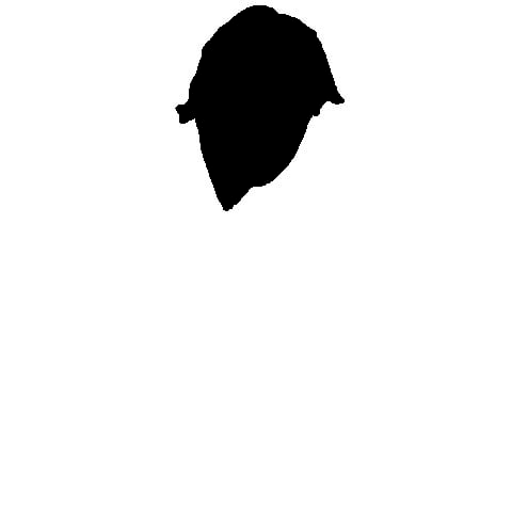

In [90]:
init_image = Image.open(f'assets/image.jpeg').convert('RGB') # .resize((512,512))
mask_image = Image.open(f'assets/mask.jpeg').convert('RGB')
mask_image = ImageOps.invert(mask_image) #.resize((512,512))

def padding(image):
    width, height = image.size
    padding = (height - width) // 2
    image_padded = ImageOps.expand(image, (padding, 0, padding, 0), fill=(255, 255, 255))
    return image_padded.resize((512, 512))

init_image = padding(init_image)
mask_image = padding(mask_image)
mask_image

### Running Stable Diffusion Inpainting

In [92]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a restaurant hugging"
# prompt = "man in a classroom"
# prompt = "two nude men"
prompt = "man in the plane"
# prompt = "man in a library"
# prompt = "two lions"

concept = "Nudity"
concept_path = f"./Concept Vectors/{concept}_SD2.npy"

# A good seed
SEED = 48715 # two: v1: 20155 ; tom: 48715 ; musk: 89069 ; generated: 52925

# Uncomment the below to generated other images
SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 1.0
guidance_scale = 7.5
num_inference_steps = 100
cof = 3

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
textEmbed = text_encoder(text_input.input_ids.to("cuda"))[0]
targetEmbed = torch.from_numpy(np.load(concept_path)).to("cuda").unsqueeze(0)
targetEmbed = targetEmbed.detach().clone()
Embed = textEmbed + cof * targetEmbed        
image_nat = pipe_inpaint(
                    prompt_embeds=textEmbed, 
                    image=init_image, 
                    mask_image=mask_image, 
                    eta=1,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    strength=strength,
                ).images[0]
image_1 = pipe_inpaint(
                    prompt_embeds=textEmbed + 3 * targetEmbed,
                    image=init_image, 
                    mask_image=mask_image, 
                    eta=1,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    strength=strength,
                ).images[0]
image_2 = pipe_inpaint(
                    prompt_embeds=textEmbed + 6 * targetEmbed,
                    image=init_image, 
                    mask_image=mask_image, 
                    eta=1,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    strength=strength,
                ).images[0]
# image_nat = recover_image(image_nat, init_image, mask_image)
image_nat

6112


RuntimeError: The size of tensor a (1024) must match the size of tensor b (768) at non-singleton dimension 2

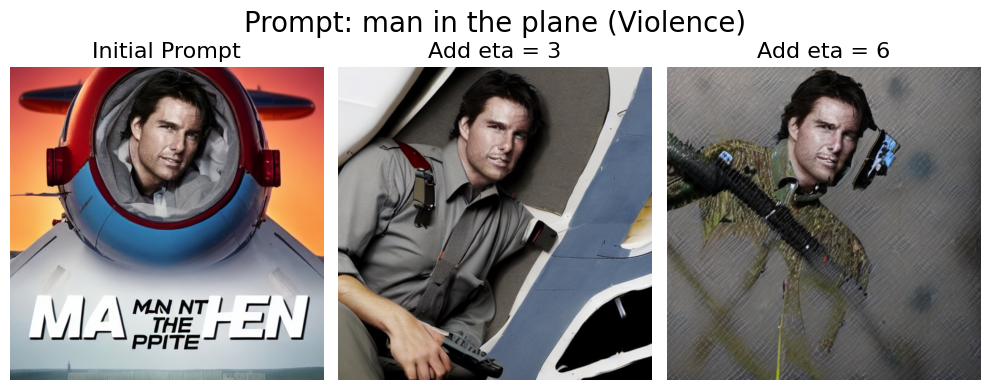

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

ax[0].imshow(image_nat)
ax[1].imshow(image_1)
ax[2].imshow(image_2)


ax[0].set_title('Initial Prompt', fontsize=16)
ax[1].set_title('Add eta = 3', fontsize=16)
ax[2].set_title('Add eta = 6', fontsize=16)

for i in range(3):
    ax[i].grid(False)
    ax[i].axis('off')
    
fig.suptitle(f"Prompt: {prompt} ({concept})", fontsize=20)
fig.tight_layout()
plt.show()